## Plot mutation prediction results

In this notebook, we'll visualize the results of our mutation prediction experiments across all data types (see `README.md` for more details). The files analyzed in this notebook are generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

In [2]:
# set results directory
results_dir = Path(cfg.results_dirs['mutation'],
                   'all_data_types_results',
                   'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

# if True, save figures to ./images directory
SAVE_FIGS = False

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
results_df = results_df[results_df.training_data.isin(['expression', 'rppa', 'mirna', 'mut_sigs'])]

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(results_df.shape)
print(results_df.seed.unique())
print(results_df.training_data.unique())
results_df.head()

(14400, 9)
[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.99984,0.998480,MAP3K1,expression,signal,42,train,0,gene
1,0.56907,0.096435,MAP3K1,expression,signal,42,test,0,gene
2,0.71757,0.376130,MAP3K1,expression,signal,42,cv,0,gene
3,1.00000,1.000000,MAP3K1,expression,signal,42,train,1,gene
4,0.84411,0.600770,MAP3K1,expression,signal,42,test,1,gene


In [4]:
# load compressed data for me_27k and me_450k
compressed_results_df = au.load_compressed_prediction_results(results_dir,
                                                              'gene',
                                                              old_filenames=True)

# make sure that we're correctly pointing to compressed methylation data
# and that we have data for one dimension and two replicates (two random seeds)
print(compressed_results_df.shape)
print(compressed_results_df.seed.unique())
print(compressed_results_df.training_data.unique())
print(compressed_results_df.n_dims.unique())
compressed_results_df.head()

(7200, 10)
[ 1 42]
['me_450k' 'me_27k']
[5000]


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,0,5000,gene
1,0.76657,0.46842,MAP3K1,me_450k,signal,1,test,0,5000,gene
2,0.63151,0.24018,MAP3K1,me_450k,signal,1,cv,0,5000,gene
3,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,1,5000,gene
4,0.74603,0.32094,MAP3K1,me_450k,signal,1,test,1,5000,gene


In [5]:
results_df['n_dims'] = 'raw'
results_df = pd.concat((results_df, compressed_results_df))
print(results_df.seed.unique())
print(results_df.training_data.unique())
print(results_df.n_dims.unique())
print(results_df.shape)
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mutational signatures',
}
results_df.training_data.replace(to_replace=training_data_map, inplace=True)
results_df.head()

[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs' 'me_450k' 'me_27k']
['raw' 5000]
(21600, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.99984,0.998480,MAP3K1,gene expression,signal,42,train,0,gene,raw
1,0.56907,0.096435,MAP3K1,gene expression,signal,42,test,0,gene,raw
2,0.71757,0.376130,MAP3K1,gene expression,signal,42,cv,0,gene,raw
3,1.00000,1.000000,MAP3K1,gene expression,signal,42,train,1,gene,raw
4,0.84411,0.600770,MAP3K1,gene expression,signal,42,test,1,gene,raw


In [6]:
all_results_df = pd.DataFrame()
for training_data in results_df.training_data.unique():
    data_df = results_df[results_df.training_data == training_data].copy()
    data_df.sort_values(by=['seed', 'fold'], inplace=True)
    data_results_df = au.compare_results(data_df,
                                         identifier='identifier',
                                         metric='aupr',
                                         correction=True,
                                         correction_method='fdr_bh',
                                         correction_alpha=SIG_ALPHA,
                                         verbose=True)
    data_results_df['training_data'] = training_data
    data_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
    all_results_df = pd.concat((all_results_df, data_results_df))
    
# now filter out genes that don't have comparisons for all data types
data_type_counts = all_results_df.groupby('gene').count().training_data
valid_genes = data_type_counts[data_type_counts == len(results_df.training_data.unique())].index
all_results_df = all_results_df[
    all_results_df.gene.isin(valid_genes)
]

all_results_df['nlog10_p'] = -np.log10(all_results_df.corr_pval)
all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
2,APC,0.481950,3.013912e-12,2.260434e-10,True,RPPA,9.645808
16,CDKN2A,0.385685,5.125952e-11,3.844464e-09,True,gene expression,8.415164
2,APC,0.556296,6.347009e-10,2.380128e-08,True,gene expression,7.623400
2,APC,0.536569,7.216273e-10,3.364598e-08,True,450k methylation,7.473067
16,CDKN2A,0.338015,8.972261e-10,3.364598e-08,True,450k methylation,7.473067
11,BRAF,0.554550,1.397637e-09,3.494092e-08,True,gene expression,7.456666
2,APC,0.534336,1.549724e-09,1.162293e-07,True,27k methylation,6.934684
57,PIK3CA,0.228634,1.951000e-09,4.877501e-08,True,450k methylation,7.311803
72,TP53,0.399211,2.214555e-09,4.152292e-08,True,gene expression,7.381712
61,PTEN,0.575846,4.797969e-09,7.196954e-08,True,gene expression,7.142851


gene expression: 34/75
27k methylation: 32/75
450k methylation: 30/75
RPPA: 25/75
microRNA: 24/75
mutational signatures: 3/75


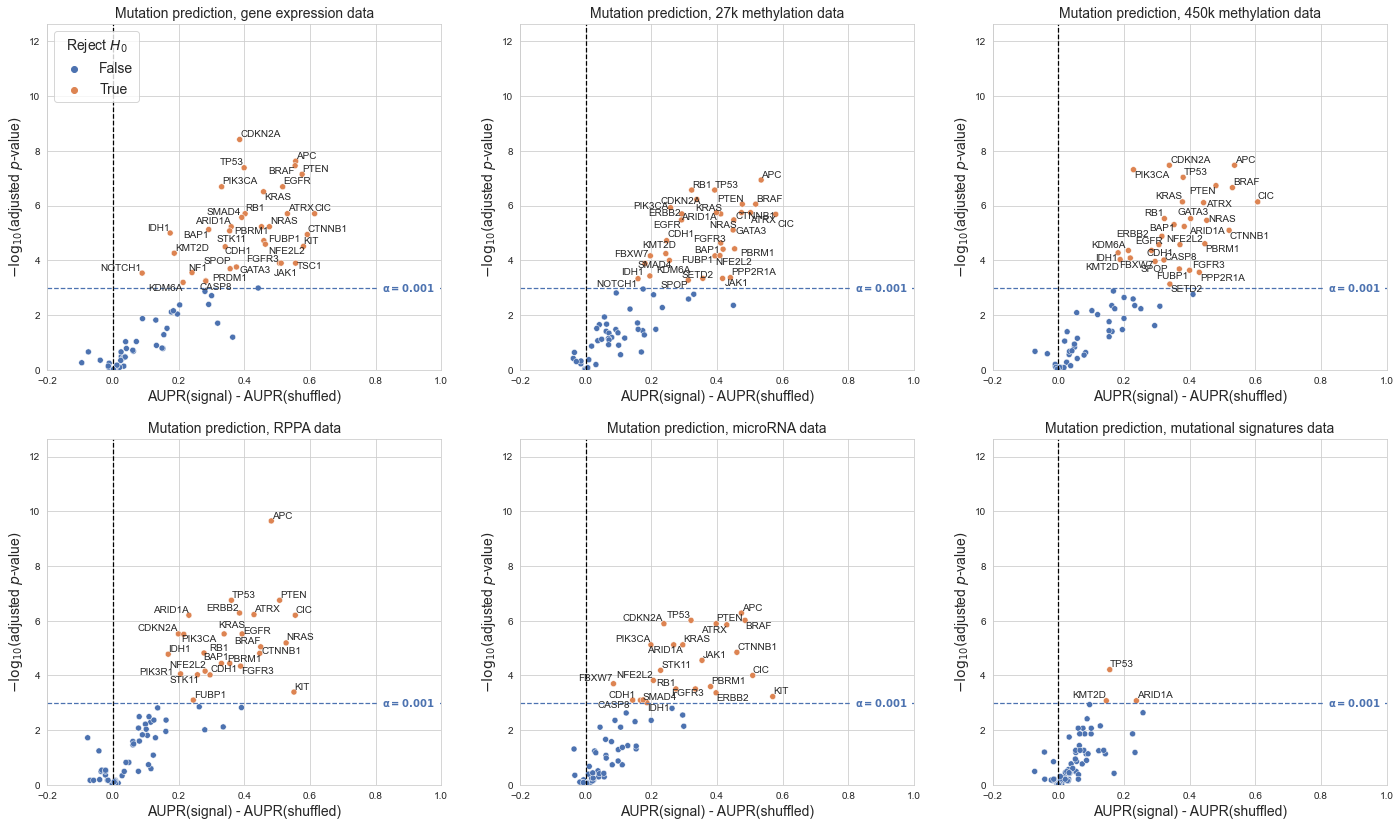

In [7]:
sns.set({'figure.figsize': (24, 14)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(2, 3)

axarr = plu.plot_volcano_baseline(all_results_df,
                                  axarr,
                                  training_data_map,
                                  SIG_ALPHA,
                                  verbose=True)

gene expression: 34/75
RPPA: 25/75
microRNA: 24/75
mutational signatures: 3/75


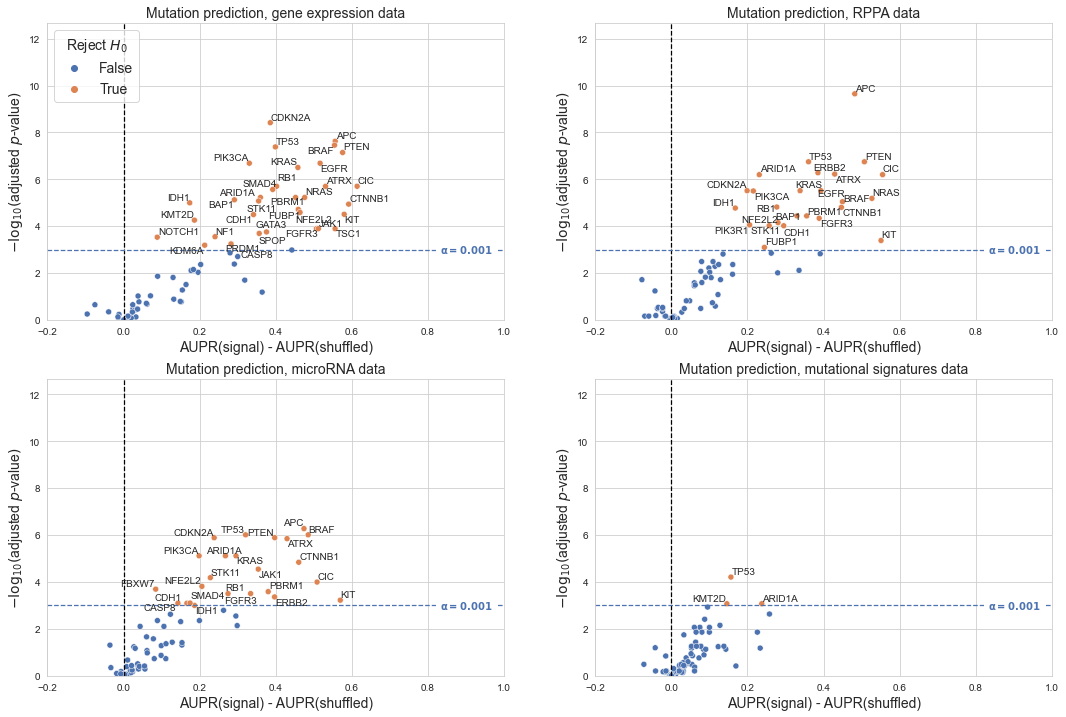

In [8]:
sns.set({'figure.figsize': (18, 12)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(2, 2)

# plot mutation prediction from expression, in a volcano-like plot
datasets = ['gene expression', 'RPPA', 'microRNA', 'mutational signatures']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

axarr = plu.plot_volcano_baseline(all_results_df,
                                  axarr,
                                  filtered_data_map,
                                  SIG_ALPHA,
                                  verbose=True)
    
if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['mutation'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'all_vs_shuffled.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_vs_shuffled.png',
                dpi=300, bbox_inches='tight')

27k methylation: 0/75
450k methylation: 1/75
RPPA: 6/75
microRNA: 9/75
mutational signatures: 28/75


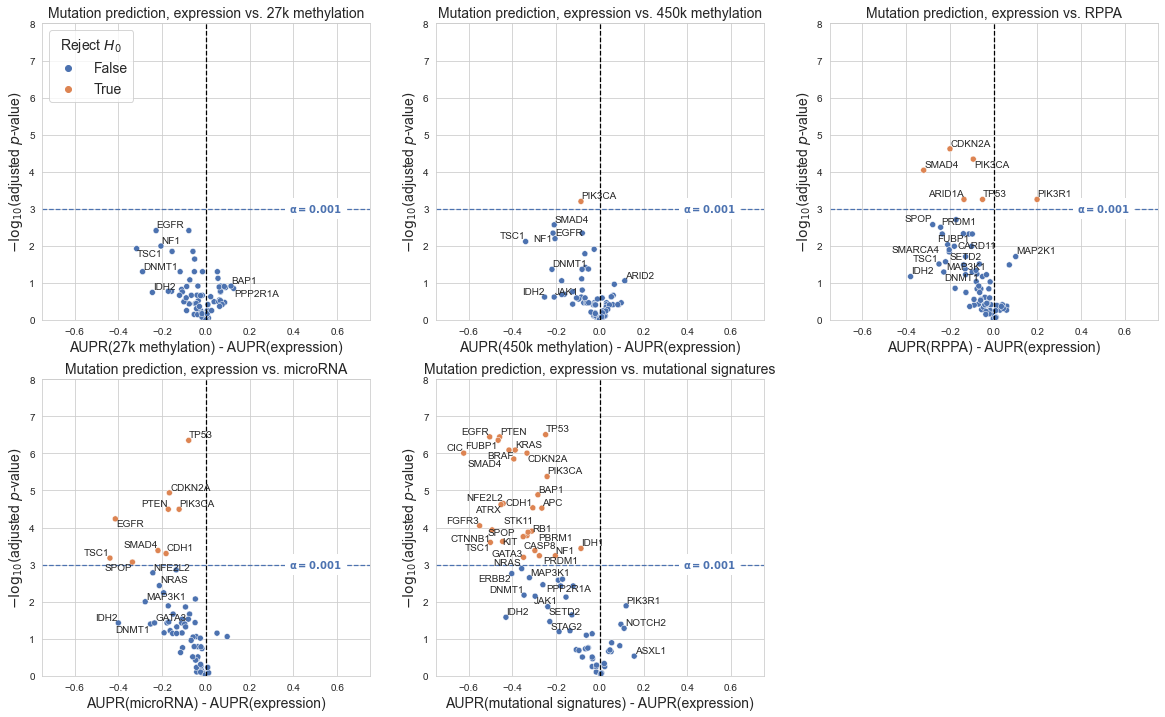

In [9]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots
sns.set({'figure.figsize': (20, 12)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(2, 3)

axarr = plu.plot_volcano_comparison(results_df,
                                    axarr,
                                    training_data_map,
                                    SIG_ALPHA,
                                    verbose=True)
    
fig.delaxes(axarr[1, 2])

RPPA: 6/75
microRNA: 9/75
mutational signatures: 28/75


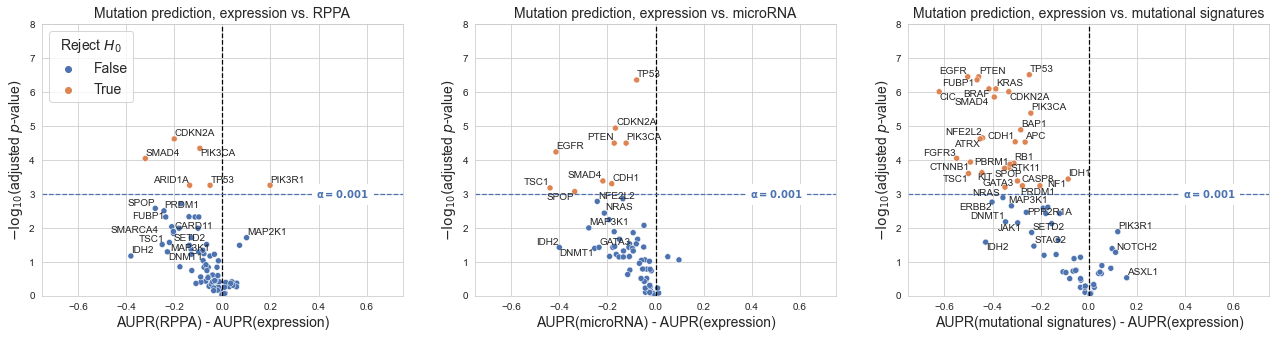

In [16]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')

datasets = ['gene expression', 'RPPA', 'microRNA', 'mutational signatures']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

fig, axarr = plt.subplots(1, 3)

axarr = plu.plot_volcano_comparison(results_df,
                                    axarr,
                                    filtered_data_map,
                                    SIG_ALPHA,
                                    verbose=True)

if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['mutation'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'all_comparison.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_comparison.png',
                dpi=300, bbox_inches='tight')